In [1]:
!pip install crewai -r ../requirements.txt

INFO: pip is looking at multiple versions of unstructured-client to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: unstructured-client
    Found existing installation: unstructured-client 0.26.1
    Uninstalling unstructured-client-0.26.1:
      Successfully uninstalled unstructured-client-0.26.1


In [2]:
import dotenv
assert dotenv.load_dotenv()

In [3]:
# Import required libraries
import os
from langchain_aws import ChatBedrock

# Set up the model ID for Claude
MODEL_ID3 = "meta.llama3-8b-instruct-v1:0"
#MODEL_ID = "meta.llama3-70b-instruct-v1:0"
#MODEL_ID = "mistral.mistral-7b-instruct-v0:2"
#MODEL_ID = "mistral.mixtral-8x7b-instruct-v0:1"
MODEL_ID2 = "anthropic.claude-3-haiku-20240307-v1:0"
MODEL_ID = "anthropic.claude-3-5-sonnet-20240620-v1:0"

# Initialize the ChatBedrock instance
llm = ChatBedrock(model_id=MODEL_ID, model_kwargs={'temperature': 0})
llm2 = ChatBedrock(model_id=MODEL_ID2, model_kwargs={'temperature': 0})
llm3 = ChatBedrock(model_id=MODEL_ID3, model_kwargs={'temperature': 0})
llm4 = ChatBedrock(model_id=MODEL_ID, model_kwargs={'temperature': 0.7})

### Basic Agentic System
based on: https://langchain-ai.github.io/langgraph/concepts/multi_agent/#sequence

In [4]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 40.6 MB/s eta 0:00:00


In [11]:
from typing import Annotated
from langchain_core.messages import SystemMessage, ToolMessage
# from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, InjectedState, create_react_agent

model = llm

def research_agent(state: Annotated[dict, InjectedState]):
    """Call research agent"""
    messages = [SystemMessage(content="You are a research assistant. Given a topic, provide key facts and information.")] + state["messages"][:-1]
    response = model.invoke(messages)
    tool_call = state["messages"][-1].tool_calls[0]
    return {"messages": [ToolMessage(response.content, tool_call_id=tool_call["id"])]}

def summarize_agent(state: Annotated[dict, InjectedState]):
    """Call summarization agent"""
    messages = [SystemMessage(content="You are a summarization expert. Condense the given information into a brief summary that is one paragraph long.")] + state["messages"][:-1]
    response = model.invoke(messages)
    tool_call = state["messages"][-1].tool_calls[0]
    return {"messages": [ToolMessage(response.content, tool_call_id=tool_call["id"])]}

tool_node = ToolNode([research_agent, summarize_agent])
graph = create_react_agent(model, [research_agent, summarize_agent], state_modifier="First research and then summarize information on a given topic.")

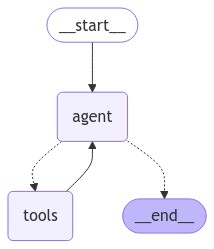

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [14]:
user_input = "What do you know about LangGraph?"
stream_graph_updates(user_input)

Assistant: 
Assistant: {'messages': [ToolMessage(content="LangGraph is a relatively new library in the field of AI and language models. Here are some key facts and information about LangGraph:\n\n1. Purpose: LangGraph is designed to build stateful, multi-agent applications using language models.\n\n2. Developer: It was developed by Harrison Chase and the team at LangChain.\n\n3. Relationship to LangChain: LangGraph is built on top of LangChain, another popular library for working with large language models.\n\n4. Functionality: It allows developers to create complex, stateful workflows and agent interactions using language models.\n\n5. Graph-based approach: LangGraph uses a graph-based structure to represent the flow of information and decision-making in applications.\n\n6. Use cases: It's particularly useful for creating chatbots, question-answering systems, and other AI applications that require maintaining context and state across multiple interactions.\n\n7. Programming language: 

### Tool Calling

In [15]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

In [16]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location == "san francisco":
        raise ValueError("Input queries must be proper nouns")
    elif location == "San Francisco":
        return "It's 60 degrees and foggy."
    else:
        raise ValueError("Invalid input.")


@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "nyc, sf"

In [17]:
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

In [18]:
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id')]}

In [20]:
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_coolest_cities",
            "args": {},
            "id": "tool_call_id_1",
            "type": "tool_call",
        },
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
    ],
)

tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='nyc, sf', name='get_coolest_cities', tool_call_id='tool_call_id_1'),
  ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id_2')]}

In [21]:
from typing import Literal

# from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

In [22]:
model_with_tools = llm.bind_tools(tools)

In [23]:
model_with_tools.invoke("what's the weather in sf?").tool_calls

[{'name': 'get_weather',
  'args': {'location': 'San Francisco'},
  'id': 'toolu_bdrk_01LUdgKm6aKf8So4ZCFL2tEU',
  'type': 'tool_call'}]

In [24]:
tool_node.invoke({"messages": [model_with_tools.invoke("what's the weather in sf?")]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='toolu_bdrk_0115eZYa5VzfVXvdC2H2WkME')]}

### ReAct agent

In [29]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

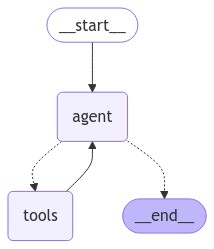

In [30]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "what is the weather in san francisco?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what is the weather in san francisco?
================================== Ai Message ==================================
Tool Calls:
  get_weather (toolu_bdrk_01UthQukvo4qhKvyqGidwcJ5)
 Call ID: toolu_bdrk_01UthQukvo4qhKvyqGidwcJ5
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

Based on the information provided by the weather tool, I can tell you that the current weather in San Francisco is:

Temperature: 60 degrees Fahrenheit
Conditions: Foggy

San Francisco is known for its microclimates and frequent fog, especially during the summer months. The moderate temperature of 60°F (about 15.5°C) is quite typical for the city, which generally has mild weather year-round. The fog, often referred to as "Karl the Fog" by l

In [28]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "what's the weather in the coolest cities?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in the coolest cities?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (toolu_bdrk_01PzMDhHk2De3B3GBz7gPfdE)
 Call ID: toolu_bdrk_01PzMDhHk2De3B3GBz7gPfdE
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

nyc, sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (toolu_bdrk_01PvAyZS3Xw4wMwm8gosRbXs)
 Call ID: toolu_bdrk_01PvAyZS3Xw4wMwm8gosRbXs
  Args:
    location: nyc
================================= Tool Message =================================
Name: get_weather

It's 90 degrees and sunny.
================================== Ai Message ==================================
Tool Calls:
  get_weather (toolu_bdrk_01JNmCoFT381H8EbGxFzKSPd)
 Call ID: toolu_bdrk_01JNmCoFT381H8EbGxFzKSPd
  Args:
    location

### Custom Error Handling Strategies

In [59]:
import json

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages.modifier import RemoveMessage

class HaikuRequest(BaseModel):
    topic: list[str] = Field(
        max_length=3,
        min_length=3,
    )

@tool(args_schema=HaikuRequest)
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    model = llm
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku


def call_tool(state: MessagesState):
    tools_by_name = {master_haiku_generator.name: master_haiku_generator}
    messages = state["messages"]
    last_message = messages[-1]
    output_messages = []
    for tool_call in last_message.tool_calls:
        try:
            # Wrap the arguments in the HaikuRequest object
            tool_args = HaikuRequest(topic=tool_call["args"]["topic"])
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_args)
            output_messages.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        except Exception as e:
            # Return the error if the tool call fails
            output_messages.append(
                ToolMessage(
                    content="",
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                    additional_kwargs={"error": str(e)},
                )
            )
    return {"messages": output_messages}


model = llm
model_with_tools = model.bind_tools([master_haiku_generator])

better_model = llm
better_model_with_tools = better_model.bind_tools([master_haiku_generator])


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def should_fallback(
    state: MessagesState,
) -> Literal["agent", "remove_failed_tool_call_attempt"]:
    messages = state["messages"]
    failed_tool_messages = [
        msg
        for msg in messages
        if isinstance(msg, ToolMessage)
        and msg.additional_kwargs.get("error") is not None
    ]
    if failed_tool_messages:
        return "remove_failed_tool_call_attempt"
    return "agent"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


def remove_failed_tool_call_attempt(state: MessagesState):
    messages = state["messages"]
    # Remove all messages from the most recent
    # instance of AIMessage onwards.
    last_ai_message_index = next(
        i
        for i, msg in reversed(list(enumerate(messages)))
        if isinstance(msg, AIMessage)
    )
    messages_to_remove = messages[last_ai_message_index:]
    return {"messages": [RemoveMessage(id=m.id) for m in messages_to_remove]}


# Fallback to a better model if a tool call fails
def call_fallback_model(state: MessagesState):
    messages = state["messages"]
    response = better_model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", call_tool)
workflow.add_node("remove_failed_tool_call_attempt", remove_failed_tool_call_attempt)
workflow.add_node("fallback_agent", call_fallback_model)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_conditional_edges("tools", should_fallback)
workflow.add_edge("remove_failed_tool_call_attempt", "fallback_agent")
workflow.add_edge("fallback_agent", "tools")

app = workflow.compile()

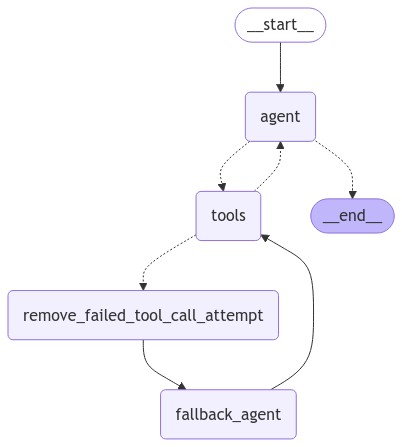

In [60]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [61]:
stream = app.stream(
    {"messages": [("human", "Write me an incredible haiku about PIRLS 2021.")]},
    {"recursion_limit": 10},
)

for chunk in stream:
    print(chunk)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 400, 'completion_tokens': 170, 'total_tokens': 570}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 400, 'completion_tokens': 170, 'total_tokens': 570}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-4e76db76-efef-4ae2-8ff0-e12827edd21e-0', tool_calls=[{'name': 'master_haiku_generator', 'args': {'topic': ['reading', 'international', 'assessment']}, 'id': 'toolu_bdrk_01RMoZqYeJr86epLs3oQfH59', 'type': 'tool_call'}], usage_metadata={'input_tokens': 400, 'output_tokens': 170, 'total_tokens': 570})]}}
{'tools': {'messages': [ToolMessage(content='', additional_kwargs={'error': "master_haiku_generator() missing 1 required positional argument: 'request'"}, name='master_haiku_generator', id='5de5d3c2-9fb8-465f-8bbc-a8ba141e0db7', tool_call_id='toolu_bdrk_01RMoZqYeJr86epLs3oQf

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

### Pass runtime values to tools

In [62]:
from typing import List

# this is the state schema used by the prebuilt create_react_agent we'll be using below
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.documents import Document


class State(AgentState):
    docs: List[str]

In [64]:
from typing import List, Tuple
from typing_extensions import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState


@tool
def get_context(question: str, state: Annotated[dict, InjectedState]):
    """Get relevant context for answering the question."""
    return "\n\n".join(doc for doc in state["docs"])

In [66]:
# from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, create_react_agent
from langgraph.checkpoint.memory import MemorySaver

model = llm
tools = [get_context]

# ToolNode will automatically take care of injecting state into tools
tool_node = ToolNode(tools)

checkpointer = MemorySaver()
graph = create_react_agent(model, tools, state_schema=State, checkpointer=checkpointer)

In [67]:
docs = [
    "FooBar company just raised 1 Billion dollars!",
    "FooBar company was founded in 2019",
]

inputs = {
    "messages": [{"type": "user", "content": "what's the latest news about FooBar"}],
    "docs": docs,
}
config = {"configurable": {"thread_id": "1"}}
for chunk in graph.stream(inputs, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the latest news about FooBar
================================== Ai Message ==================================
Tool Calls:
  get_context (toolu_bdrk_01CeM1CZW5SJ9a2rJhYByL6v)
 Call ID: toolu_bdrk_01CeM1CZW5SJ9a2rJhYByL6v
  Args:
    question: What's the latest news about FooBar?
================================= Tool Message =================================
Name: get_context

FooBar company just raised 1 Billion dollars!

FooBar company was founded in 2019
================================== Ai Message ==================================

Based on the context provided, I can share the latest news about FooBar:

FooBar, a company founded in 2019, has just raised an impressive $1 billion in funding. This is a significant development for the relatively young company and suggests strong investor confidence in their business model or technology.

The billion-dollar funding round is the most recent and not

In [68]:
from langgraph.store.memory import InMemoryStore

doc_store = InMemoryStore()

namespace = ("documents", "1")  # user ID
doc_store.put(
    namespace, "doc_0", {"doc": "FooBar company just raised 1 Billion dollars!"}
)
namespace = ("documents", "2")  # user ID
doc_store.put(namespace, "doc_1", {"doc": "FooBar company was founded in 2019"})

In [74]:
from pydantic import BaseModel

class CustomConfig(BaseModel):
    store: BaseStore

    class Config:
        arbitrary_types_allowed = True  # Allow arbitrary types like BaseStore

In [27]:
!pip install --upgrade langchain-core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [81]:
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import InjectedStore


@tool
def get_context(
    question: str,
    config: RunnableConfig,
    store: Annotated[BaseStore, InjectedStore()],  # Keep InjectedStore
) -> Tuple[str, List[Document]]:
    """Get relevant context for answering the question."""
    user_id = config.get("configurable", {}).get("user_id")
    docs = [item.value["doc"] for item in store.search(("documents", user_id))]
    return "\n\n".join(doc for doc in docs)

ValueError: Value not declarable with JSON Schema, field: name='store' type=BaseStore required=True

### Structured Output

In [5]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

class ResponseFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""

    answer: str = Field(description="The answer to the user's question in markdown format. Each paragraph starts with an emoji and a heading in capital letters. Use tables to increase readability.")

model = llm

model_with_tools = model.bind_tools([ResponseFormatter])

ai_msg = model_with_tools.invoke("What is PIRLS 2021 about?")

ai_msg.tool_calls[0]["args"]["answer"]

"\n📚 INTRODUCTION TO PIRLS 2021\n\nPIRLS 2021 stands for Progress in International Reading Literacy Study 2021. It is an international assessment of reading comprehension at the fourth grade level.\n\n🌍 GLOBAL SCOPE\n\n- Conducted by the International Association for the Evaluation of Educational Achievement (IEA)\n- Involves students from countries and education systems worldwide\n- Allows for international comparisons of reading achievement\n\n📊 KEY FEATURES\n\n1. Target Population: Fourth-grade students (typically 9-10 years old)\n2. Assessment Cycle: Conducted every five years since 2001\n3. Focus: Reading literacy in both literary and informational texts\n\n🔍 ASSESSMENT COMPONENTS\n\n| Component | Description |\n|-----------|-------------|\n| Reading Test | Measures students' reading comprehension skills |\n| Student Questionnaire | Gathers information about students' reading attitudes and habits |\n| Home Questionnaire | Collects data on home support for literacy |\n| Teacher Que

In [6]:
ai_msg.tool_calls[0]["args"]["answer"]

"\n📚 INTRODUCTION TO PIRLS 2021\n\nPIRLS 2021 stands for Progress in International Reading Literacy Study 2021. It is an international assessment of reading comprehension at the fourth grade level.\n\n🌍 GLOBAL SCOPE\n\n- Conducted by the International Association for the Evaluation of Educational Achievement (IEA)\n- Involves students from countries and education systems worldwide\n- Allows for international comparisons of reading achievement\n\n📊 KEY FEATURES\n\n1. Target Population: Fourth-grade students (typically 9-10 years old)\n2. Assessment Cycle: Conducted every five years since 2001\n3. Focus: Reading literacy in both literary and informational texts\n\n🔍 ASSESSMENT COMPONENTS\n\n| Component | Description |\n|-----------|-------------|\n| Reading Test | Measures students' reading comprehension skills |\n| Student Questionnaire | Gathers information about students' reading attitudes and habits |\n| Home Questionnaire | Collects data on home support for literacy |\n| Teacher Que

\n📚 INTRODUCTION TO PIRLS 2021\n\nPIRLS 2021 stands for Progress in International Reading Literacy Study 2021. It is an international assessment of reading comprehension at the fourth grade level.\n\n🌍 GLOBAL SCOPE\n\n- Conducted by the International Association for the Evaluation of Educational Achievement (IEA)\n- Involves students from countries and education systems worldwide\n- Allows for international comparisons of reading achievement\n\n📊 KEY FEATURES\n\n1. Target Population: Fourth-grade students (typically 9-10 years old)\n2. Assessment Cycle: Conducted every five years since 2001\n3. Focus: Reading literacy in both literary and informational texts\n\n🔍 ASSESSMENT COMPONENTS\n\n| Component | Description |\n|-----------|-------------|\n| Reading Test | Measures students' reading comprehension skills |\n| Student Questionnaire | Gathers information about students' reading attitudes and habits |\n| Home Questionnaire | Collects data on home support for literacy |\n| Teacher Questionnaire | Provides insights into classroom practices and resources |\n| School Questionnaire | Examines school-level factors affecting reading achievement |\n\n📈 OBJECTIVES OF PIRLS 2021\n\n1. Measure and compare reading achievement across participating countries\n2. Identify trends in reading performance over time\n3. Explore factors influencing reading development\n4. Inform educational policies and practices related to reading instruction\n\n🔬 SPECIAL FEATURES OF PIRLS 2021\n\n- Inclusion of digital assessment (ePIRLS) to measure online reading skills\n- Adaptations to address challenges posed by the COVID-19 pandemic\n- Enhanced focus on equity and inclusion in reading education\n\nPIRLS 2021 provides valuable insights into global reading literacy trends, helping educators and policymakers make informed decisions to improve reading instruction and student outcomes worldwide.\n

### RAG - Prompt

In [5]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 72.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 36.3 MB/s eta 0:00:00


In [6]:
# !pip install upgrade langchain-community

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


In [7]:
!pip install -U langchain-huggingface==0.1.0

  Using cached langchain_core-0.3.10-py3-none-any.whl.metadata (6.3 kB)
Using cached langchain_core-0.3.10-py3-none-any.whl (404 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.2.41
    Uninstalling langchain-core-0.2.41:
      Successfully uninstalled langchain-core-0.2.41
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.2.15 requires langchain-core<0.3.0,>=0.2.35, but you have langchain-core 0.3.10 which is incompatible.
langchain-aws 0.1.17 requires langchain-core<0.3,>=0.2.33, but you have langchain-core 0.3.10 which is incompatible.
langchain-cohere 0.1.9 requires langchain-core<0.3,>=0.2.2, but you have langchain-core 0.3.10 which is incompatible.
langchain-community 0.2.15 requires langchain-core<0.3.0,>=0.2.37, but you have langchain-core 0.3.10 which is incompatible.
langchain-experimental 0.0.64 

In [20]:
!pip install unstructured

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 57.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 82.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 75.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 4.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 12.5 MB/s e

In [34]:
!pip install --upgrade pydantic==2.8.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Using cached pydantic_core-2.20.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
Using cached pydantic-2.8.2-py3-none-any.whl (423 kB)
Using cached pydantic_core-2.20.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.23.4
    Uninstalling pydantic_core-2.23.4:
      Successfully uninstalled pydantic_core-2.23.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.9.2
    Uninstalling pydantic-2.9.2:
      Successfully uninstalled pydantic-2.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-huggingface 0.1.0 requires langchain-core<0.4,>=0.3.0, but you have langchain-core 0.2.41 which is incompatible.
unstructured-client 0.26.

In [8]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

In [9]:
# Instantiate Hugging Face embeddings
hf_embeddings = hf

In [12]:
from langchain.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

# URL of the PDF document
pdf_url = "https://pirls2021.org/wp-content/uploads/2022/files/Singapore.pdf"  # Replace with actual URL

# Load the PDF from the URL
loader = PyPDFLoader(file_path=pdf_url)
pdf_docs = loader.load()

# Add metadata (source) to each document
for doc in pdf_docs:
    doc.metadata["source"] = pdf_url  # Add URL as the source

# Split the document into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50
)
splits = text_splitter.split_documents(pdf_docs)

# Create the vectorstore using Hugging Face embeddings and IDs
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=hf_embeddings)

retriever = vectorstore.as_retriever()


# # Optional: Store embeddings to pickle
# with open("policy_pdf_embeddings.pkl", "wb") as f:
#     pickle.dump(splits, f)

# # Retrieve the metadata (source) for each chunk
# for doc in splits:
#     print(f"Document chunk from source: {doc.metadata.get('source', 'Unknown source')}")

# print("Embeddings for the PDF file have been saved to policy_pdf_embeddings.pkl")


In [17]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import WebBaseLoader


target_url = "https://pirls2021.org/results/international-benchmarks/percentages"
loader = WebBaseLoader(
    web_paths=(target_url,),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer("p")
    ),
)
blog_docs = loader.load()

# Add metadata for web source (URL)
for doc in blog_docs:
    doc.metadata["source"] = target_url

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)



# Make splits
splits = text_splitter.split_documents(blog_docs)

# Create the vectorstore using Hugging Face embeddings and IDs
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=hf_embeddings)

retriever = vectorstore.as_retriever()

In [18]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate three 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
# from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | llm 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [19]:
from pydantic import BaseModel

class Config:
    arbitrary_types_allowed = True

In [20]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What factors enhance children's reading skills?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

RuntimeError: no validator found for <class 'langchain_core.runnables.base.Runnable'>, see `arbitrary_types_allowed` in Config

In [16]:
docs

[Document(metadata={'page': 17, 'source': 'Singapore.pdf'}, page_content='24  National Library Board, Singapore. (2021). discoveReads . Retrieved from https://childrenandteens.nlb.gov.sg/  \n25  National Library Board, Singapore. (2022). About national reading movement . Retrieved from \nhttps://readingnation.nlb.gov.sg/about -us/about -national- reading -movement/  \n26  Ministry of Education, Singapore. (2014). School -based dyslexia remediation programme (SDR) . Retrieved from \nhttps://www.schoolbag.sg/story/school- based -dyslexia -remediation- programme -(sdr)#.V85rd_kaZuE  \n27  Ministry of Education, Singapore.  (2021). Spec ial educational needs support at mainstream primary schools . \nRetrieved from https://www.moe.gov.sg/special- educational -needs/school-support/primary- schools  \n28  Government of Singapore. (2020). COVID -19 circuit breaker: Heightened safe -distancing measures to reduce \nmovement . Retrieved from https://www.gov.sg/article/covid -19-circuit -breaker- 

In [18]:
from operator import itemgetter
# from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}

The answer to the user's question in markdown format. Mention your PDF source at the beginning and make clear that the following points are extracts from it. Each paragraph starts with an emoji and a heading in capital letters. Use bullet points (starting with emoji) and tables to increase readability. Make direct quotations and cite your sources with a link. Also refer to sources (links) that are mentioned in relation to your citations.
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Based on the Singapore.pdf source, here are some key factors that enhance children\'s reading skills:\n\n📚 EARLY INTERVENTION\n\n- 🔍 Screening at the start of first grade to identify children lacking appropriate English language and early literacy skills\n- 🧠 Learning Support Program provides additional instructional support for the first two years\n- 🏫 School-Based Dyslexia Remediation Program offers further literacy support for diagnosed students in Grades 3 and 4\n\n> "At the beginning of first grade (Primary 1), a screening tool is used to identify children without developmentally appropriate English language and basic early literacy skills. These students are then placed in the Learning Support Program for additional instructional support on top of their regular English lessons." [Source](https://www.moe.gov.sg/special-educational-needs/school-support/primary-schools)\n\n📖 STRUCTURED APPROACH TO READING\n\n- 🎯 Systematic and skills-focused lessons\n- 👥 Small group instruction (8-

### Routing

In [34]:
# from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

chain = (
    PromptTemplate.from_template(
        """Given the user question below, classify it on a scale from 0 to 5 as either being a closed question (1-2), open question (3-4), very open question (5) or out of scope (0).

Do not respond with more than one number.
Only questions related to PIRLS 2021 are in your scope.

<question>
{question}
</question>

Classification:"""
    )
    | llm
    | StrOutputParser()
)

chain.invoke({"question": "Give me a chocolate cake recipe."})

'0'

In [35]:
closed_chain = PromptTemplate.from_template(
    """You are an expert in PIRLS 2021. \
Your answer should not be longer than 1 or 2 paragraphs". \
The answer to the user's question in markdown format. Each paragraph starts with an emoji and a heading in capital letters. Use tables to increase readability. \
Respond to the following question:

Question: {question}
Answer:"""
) | llm
open_chain = PromptTemplate.from_template(
    """You are an expert in PIRLS 2021. \
Your answer should not be longer than 3 or 4 paragraphs". \
The answer to the user's question in markdown format. Each paragraph starts with an emoji and a heading in capital letters. Use tables to increase readability. \
Respond to the following question:

Question: {question}
Answer:"""
) | llm
very_open_chain = PromptTemplate.from_template(
    """You are an expert in PIRLS 2021. \
Your answer should not be longer than 5 paragraphs". \
The answer to the user's question in markdown format. Each paragraph starts with an emoji and a heading in capital letters. Use tables to increase readability. \
Respond to the following question:

Question: {question}
Answer:"""
) | llm
out_of_scope_chain = PromptTemplate.from_template(
    """You are witty and playful communications specialist. \
Provide a poem that playfulle combines the user question and PIRLS 2021. \

Question: {question}
Answer:"""
) | llm

In [36]:
def route(info):
    if "1" or "2" in info["topic"].lower():
        return closed_chain
    elif "3" or "4" in info["topic"].lower():
        return open_chain
    elif "5" in info["topic"].lower():
        return very_open_chain
    else:
        return out_of_scope_chain

In [37]:
from langchain_core.runnables import RunnableLambda

full_chain = {"topic": chain, "question": lambda x: x["question"]} | RunnableLambda(
    route
)

In [38]:
full_chain.invoke({"question": "Give me a chocolate cake recipe."})

AIMessage(content="🍰 CHOCOLATE CAKE RECIPE\n\nI apologize, but as an expert in PIRLS 2021 (Progress in International Reading Literacy Study), I don't have a chocolate cake recipe to share. PIRLS is an international assessment of reading comprehension for fourth-grade students. It focuses on evaluating reading literacy skills and doesn't involve culinary topics or recipes.\n\n🔍 PIRLS FOCUS\n\nIf you're interested in learning about PIRLS 2021, I'd be happy to provide information on its methodology, participating countries, or key findings related to reading achievement among young students. However, for a chocolate cake recipe, I recommend consulting a cookbook or culinary website.", additional_kwargs={'usage': {'prompt_tokens': 88, 'completion_tokens': 153, 'total_tokens': 241}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 88, 'completion_tokens': 153, 'total_tokens': 241}, 'stop_reason': 'end_turn', '